# Лабораторна робота — Підбір гіперпараметрів з Keras Tuner

Цей ноутбук містить готові заготовки для частин 1–4 практичної роботи, описані українською.
Запустіть у середовищі з GPU (якщо доступний) для прискорення тренування.

**Інструкції:** перегляньте та за потреби змініть `max_trials`, `epochs`, `batch_size` перед запуском підбору.

## Частина 1

In [1]:
# Установка та імпорт пакетів (розкоментуйте установку, якщо потрібно)
# !pip install -U keras-tuner

import tensorflow as tf
from IPython.core.display import Image
from keras._tf_keras.keras.preprocessing import image
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils, layers
import numpy as np
import os



TensorFlow version: 2.20.0


In [2]:
# Підготовка даних (як у умові)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(60000, 784).astype('float32') / 255.0
x_test  = x_test.reshape(10000, 784).astype('float32') / 255.0

y_train = utils.to_categorical(y_train, 10)
y_test  = utils.to_categorical(y_test, 10)

print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)


x_train shape: (60000, 784) y_train shape: (60000, 10)


### 1) Функція `build_model()` — проста мережа з **вхідним** та **вихідним** шаром

In [3]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=128, max_value=1024, step=32),
                    input_dim=784,
                    activation='relu'))  # фіксована relu
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


### 2) Створюємо RandomSearch тюнер, виводимо простір пошуку та запускаємо пошук

In [4]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=6,
    executions_per_trial=1,
    directory='tuner_part1_dir',
    project_name='part1_random'
)

# Показати простір пошуку
tuner.search_space_summary()



Search space summary
Default search space size: 1
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}


C:\Users\dasav\AppData\Local\Temp\ipykernel_17248\4265086762.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
C:\Users\dasav\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
tuner.search(x_train,                  # Дані для навчання
             y_train,                  # Вірні відповіді
             batch_size=256,           # Розмір міні-вибірки
             epochs=20,                # Кількість епох навчання
             validation_split=0.2,     # Частина даних, яка буде використовуватися для перевірки
             )

Trial 6 Complete [00h 02m 10s]
val_accuracy: 0.8381666541099548

Best val_accuracy So Far: 0.8425833582878113
Total elapsed time: 00h 14m 02s


In [6]:
tuner.results_summary()

Results summary
Results in tuner_part1_dir\part1_random
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
units_input: 800
Score: 0.8425833582878113

Trial 0 summary
Hyperparameters:
units_input: 736
Score: 0.8419166803359985

Trial 1 summary
Hyperparameters:
units_input: 480
Score: 0.8399166464805603

Trial 2 summary
Hyperparameters:
units_input: 384
Score: 0.8397499918937683

Trial 5 summary
Hyperparameters:
units_input: 576
Score: 0.8381666541099548

Trial 3 summary
Hyperparameters:
units_input: 320
Score: 0.8356666564941406


### 3) Збереження найкращої моделі та використання для передбачень на власних зображеннях

In [7]:
models = tuner.get_best_models(num_models=3)

In [8]:
for model in models:
  model.summary()
  model.evaluate(x_test, y_test)
  print()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 800)            │       628,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         8,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 636,010 (2.43 MB)

 Trainable params: 636,010 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8326 - loss: 0.4871



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 736)            │       577,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         7,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 585,130 (2.23 MB)

 Trainable params: 585,130 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8352 - loss: 0.4850



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 480)            │       376,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         4,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 381,610 (1.46 MB)

 Trainable params: 381,610 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8282 - loss: 0.4929



In [22]:
top_model=tuner.get_best_models(num_models=1)
top_model[0].save('models/task1-best.keras')

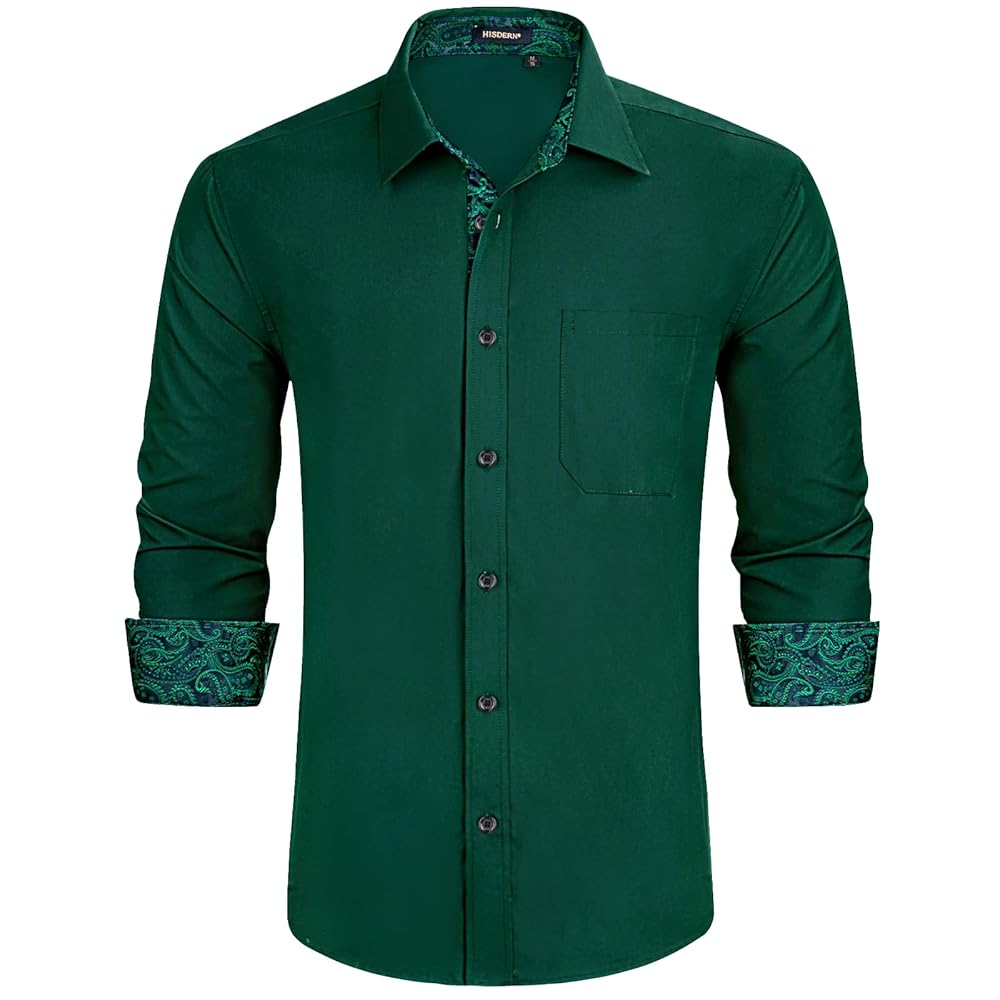

In [9]:
Image('shirt.jpg', width=150, height=150)

In [11]:
img = image.load_img('shirt.jpg', target_size=(28, 28), color_mode = "grayscale")

In [12]:
# Перетворюмо картинку в масив
x = image.img_to_array(img)
# Змінюємо форму масиву в плаский вектор
x = x.reshape(1, 784)
# Інвертуємо зображення
x = 255 - x
# Нормалізуємо зображення
x /= 255

In [18]:
classes = ['футболка', 'брюки', 'светр', 'плаття', 'пальто', 'туфлі', 'сорочка', 'кросівки', 'сумка', 'чоботи']
prediction = top_model[0].predict(x)
prediction = np.argmax(prediction)
print("Номер класу:", prediction)
print("Назва класу:", classes[prediction])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
Номер класу: 6
Назва класу: сорочка
